## Import statements

In [39]:
#imports
import pandas as pd
df = pd.read_csv('ProcessedData.tsv', delimiter = '\t', encoding = 'utf-8')
df.head(5)

,NewCategory,title,author,published_date,updated_on,slug,blurb,body
0,Business & Finance,Bitcoin is down 60 percent this year. Here's w...,Timothy B. Lee,3/31/2014 14:01,12/16/2014 16:37,http://www.vox.com/2014/3/31/5557170/bitcoin-b...,Bitcoins have lost more than 60 percent of the...,The markets haven't been kind to Bitcoin in 20...
1,Crime,6 health problems marijuana could treat better...,German Lopez,3/31/2014 15:44,11/17/2014 0:20,http://www.vox.com/2014/3/31/5557700/six-probl...,Medical marijuana could fill gaps that current...,Twenty states have so far legalized the medica...
2,Business & Finance,9 charts that explain the history of global we...,Matthew Yglesias,4/10/2014 13:30,12/16/2014 15:47,http://www.vox.com/2014/4/10/5561608/9-charts-...,These nine charts from Thomas Piketty's new bo...,Thomas Piketty's book Capital in the 21st Cent...
3,Crime,Remember when legal marijuana was going to sen...,German Lopez,4/3/2014 23:25,5/6/2014 21:58,http://www.vox.com/2014/4/3/5563134/marijuana-...,"Three months after legalizing marijuana, Denve...",When Colorado legalized recreational marijuana...
4,Technology & Health,Obamacare succeeded for one simple reason: it'...,Sarah Kliff,4/1/2014 20:26,11/18/2014 15:09,http://www.vox.com/2014/4/1/5570780/the-two-re...,"After a catastrophic launch, Obamacare still s...",There's a very simple reason that Obamacare hi...


In [40]:
print('The shape is:', df.shape)

The shape is: (11683, 8)


In [41]:
#creating category_id feature
from io import StringIO
col = ['NewCategory', 'title']
df = df[col]
df = df[pd.notnull(df['title'])]
df.columns = ['NewCategory', 'title']
df['category_id'] = df['NewCategory'].factorize()[0]
category_id_df = df[['NewCategory', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'NewCategory']].values)
df.head()

,NewCategory,title,category_id
0,Business & Finance,Bitcoin is down 60 percent this year. Here's w...,0
1,Crime,6 health problems marijuana could treat better...,1
2,Business & Finance,9 charts that explain the history of global we...,0
3,Crime,Remember when legal marijuana was going to sen...,1
4,Technology & Health,Obamacare succeeded for one simple reason: it'...,2


## Creating new features

In [42]:
#creating numeric features for title
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.title).toarray()
labels = df.NewCategory
features.shape


(11683, 3821)

In [43]:
#Terms in the form of unigram and bigram that are most correlated to each category
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for title, category in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '0':
  . Most correlated unigrams:
. finale
. zuckerberg
  . Most correlated bigrams:
. fight ebola
. financial crisis
# '1':
  . Most correlated unigrams:
. finale
. zuckerberg
  . Most correlated bigrams:
. fight ebola
. financial crisis
# '4':
  . Most correlated unigrams:
. finale
. zuckerberg
  . Most correlated bigrams:
. fight ebola
. financial crisis
# '3':
  . Most correlated unigrams:
. finale
. zuckerberg
  . Most correlated bigrams:
. fight ebola
. financial crisis
# '2':
  . Most correlated unigrams:
. finale
. zuckerberg
  . Most correlated bigrams:
. fight ebola
. financial crisis


## Spiltting the Data into Training and Testing

In [44]:
#Training and Testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size = 0.2, random_state = 0)

## Training Decision Tree Classifier

In [49]:
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=2)  
classifier.fit(X_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [46]:
y_pred = classifier.predict(X_test)

In [47]:

from sklearn.metrics import accuracy_score 
acc = accuracy_score(y_test, y_pred)
print(acc)

0.34959349593495936


## Hyperparameter Tuning

In [50]:

classifier = KNeighborsClassifier(n_neighbors=35)  
classifier.fit(X_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=35, p=2,
                     weights='uniform')

In [51]:
y_pred = classifier.predict(X_test)

## Performance Metrics

1. Accuracy

In [52]:
from sklearn.metrics import accuracy_score 
acc = accuracy_score(y_test, y_pred)
print("Accuracy of KNN Classifier after tuning:", acc*100)

Accuracy of KNN Classifier after tuning: 75.52417629439452


2. F1 Score

In [53]:
from sklearn.metrics import f1_score
print("F1 Score for all the categories:")
b= f1_score(y_test, y_pred, average=None)
b

F1 Score for all the categories:


array([0.2384106 , 0.66562009, 0.72804533, 0.83652762, 0.63583815])

3. Confusion Matrix

In [54]:
from sklearn.metrics import confusion_matrix
m=confusion_matrix(y_test, y_pred)
m

array([[  18,    5,   20,   66,   15],
       [   1,  212,   19,  121,   12],
       [   3,    8,  257,   70,   21],
       [   4,   38,   28, 1113,   32],
       [   1,    9,   23,   76,  165]])

4. Precision-Recall

In [55]:
from sklearn.metrics import classification_report
report = classification_report(y_test,y_pred,output_dict=True)
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

 Business & Finance       0.67      0.15      0.24       124
              Crime       0.78      0.58      0.67       365
      Entertainment       0.74      0.72      0.73       359
           Politics       0.77      0.92      0.84      1215
Technology & Health       0.67      0.60      0.64       274

           accuracy                           0.76      2337
          macro avg       0.73      0.59      0.62      2337
       weighted avg       0.75      0.76      0.74      2337



In [56]:
df11 = pd.DataFrame(report).transpose()
df11

,precision,recall,f1-score,support
Business & Finance,0.666667,0.145161,0.238411,124.000000
Crime,0.779412,0.580822,0.665620,365.000000
Entertainment,0.740634,0.715877,0.728045,359.000000
Politics,0.769710,0.916049,0.836528,1215.000000
Technology & Health,0.673469,0.602190,0.635838,274.000000
accuracy,0.755242,0.755242,0.755242,0.755242
macro avg,0.725978,0.592020,0.620888,2337.000000
weighted avg,0.750007,0.755242,0.737905,2337.000000


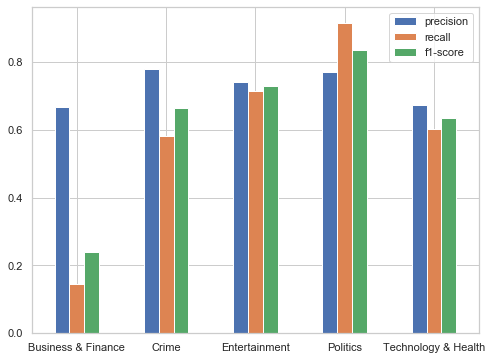

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
bb= ['precision','recall','f1-score']
# a simple line plot
df11.iloc[0:5].plot(kind='bar',y= bb,figsize=(8,6),rot=0)

In [58]:
#import seaborn as sns
#sns.set(style="whitegrid")
#tips = sns.load_dataset("tips")
#ax = sns.barplot(x = df['NewCategory'], y=b, data=df)
#ax = sns.barplot(x="day", y="total_bill", hue="sex", data=tips)

In [60]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(np.unique(labels))-0.5)
    plt.ylim(len(np.unique(labels))-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

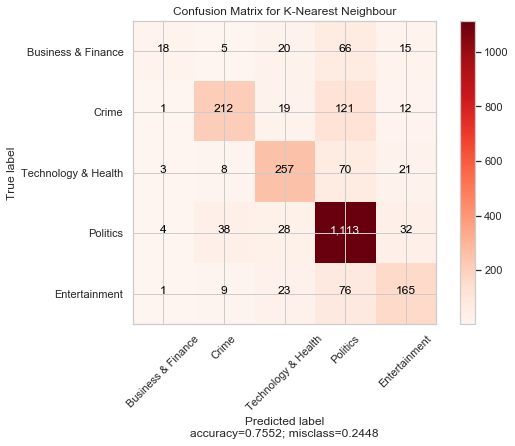

In [61]:
plot_confusion_matrix(cm           =m, 
                                     normalize    = False,
                                    target_names = ['Business & Finance', 'Crime', 'Technology & Health', 'Politics','Entertainment'],
                                    title        = "Confusion Matrix for K-Nearest Neighbour")